/home/guest03/Software/anaconda3/envs/dm2f/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guest03/Software/anaconda3/envs/dm2f/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load snapshot 'iter_40000_loss_0.01244_lr_0.000000' for testing


/home/guest03/Software/anaconda3/envs/dm2f/lib/python3.12/site-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/guest03/Software/anaconda3/envs/dm2f/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


predicting for SOTS (1/500) [1407_7]: PSNR 34.3383, SSIM 0.9853
predicting for SOTS (2/500) [1443_3]: PSNR 35.4390, SSIM 0.9742
predicting for SOTS (3/500) [1422_2]: PSNR 39.8223, SSIM 0.9739
predicting for SOTS (4/500) [1447_4]: PSNR 33.2330, SSIM 0.9739
predicting for SOTS (5/500) [1411_1]: PSNR 36.9123, SSIM 0.9787
predicting for SOTS (6/500) [1439_4]: PSNR 34.6749, SSIM 0.9846
predicting for SOTS (7/500) [1416_8]: PSNR 31.3398, SSIM 0.9840
predicting for SOTS (8/500) [1445_8]: PSNR 32.9814, SSIM 0.9759
predicting for SOTS (9/500) [1441_5]: PSNR 37.9098, SSIM 0.9810
predicting for SOTS (10/500) [1405_3]: PSNR 35.0341, SSIM 0.9816
predicting for SOTS (11/500) [1401_9]: PSNR 32.6097, SSIM 0.9705
predicting for SOTS (12/500) [1429_8]: PSNR 32.2011, SSIM 0.9562
predicting for SOTS (13/500) [1437_6]: PSNR 34.6584, SSIM 0.9800
predicting for SOTS (14/500) [1435_1]: PSNR 39.8606, SSIM 0.9920
predicting for SOTS (15/500) [1402_3]: PSNR 36.0829, SSIM 0.9644
predicting for SOTS (16/500) [1402

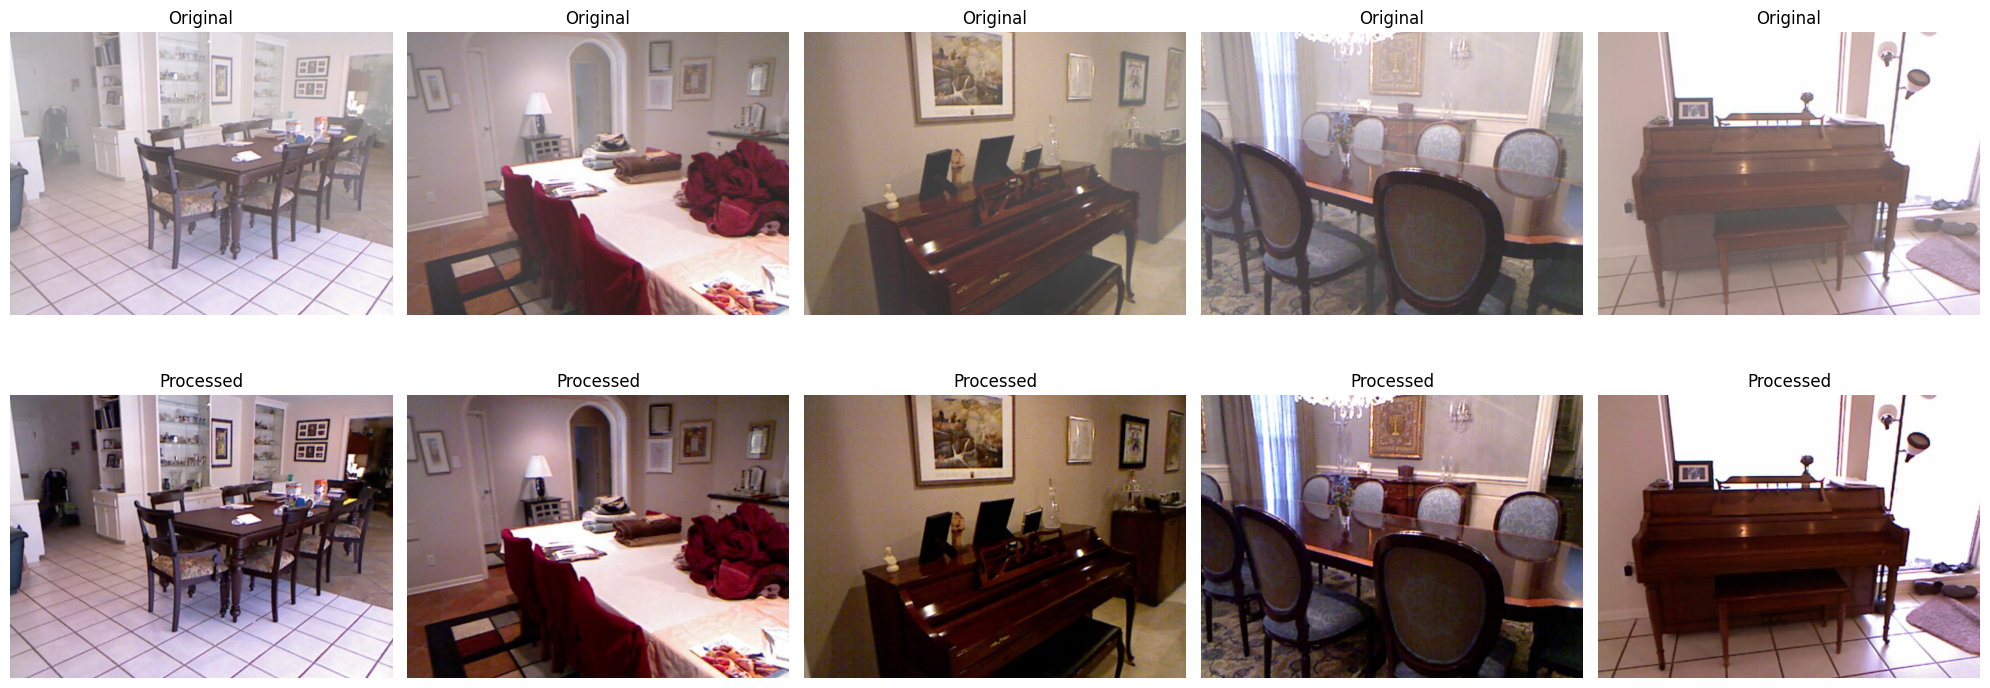

[SOTS] L1: 0.012438, PSNR: 35.058292, SSIM: 0.977895


In [1]:
# coding: utf-8
import os

import numpy as np
import torch
from torch import nn
from torchvision import transforms

from tools.config import TEST_SOTS_ROOT, OHAZE_ROOT
from tools.utils import AvgMeter, check_mkdir, sliding_forward
from model import DM2FNet, DM2FNet_woPhy
from datasets import SotsDataset, OHazeDataset
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import matplotlib.pyplot as plt

from skimage.metrics import mean_squared_error
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from skimage import color

def calculate_ciede2000(img1, img2):
    """ Calculate the average CIEDE2000 color difference between two images. """
    # Ensure the images are in the range [0, 1] for color conversion
    # img1 = img1 / 255.0
    # img2 = img2 / 255.0
    # total_delta_e = 0
    # for i in range(img1.shape[0]):
    #     for j in range(img1.shape[1]):
    #         color1 = sRGBColor(img1[i, j, 0], img1[i, j, 1], img1[i, j, 2], is_upscaled=False)
    #         color2 = sRGBColor(img2[i, j, 0], img2[i, j, 1], img2[i, j, 2], is_upscaled=False)
    #         lab1 = convert_color(color1, LabColor)
    #         lab2 = convert_color(color2, LabColor)
    #         delta_e = delta_e_cie2000(lab1, lab2)
    #         total_delta_e += delta_e
    # return total_delta_e / (img1.shape[0] * img1.shape[1])
    lab1 = color.rgb2lab(img1 / 255.0)  # 确保输入范围正确
    lab2 = color.rgb2lab(img2 / 255.0)
    print(type(lab1))
    
    # 计算所有像素的 CIEDE2000 色差
    delta_e = delta_e_cie2000(lab1, lab2)
    
    # 返回平均色差
    return np.mean(delta_e)

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

torch.manual_seed(2018)
# torch.cuda.set_device(0)

ckpt_path = './ckpt'
exp_name = 'RESIDE_ITS'
# exp_name = 'O-Haze'

args = {
    # 'snapshot': 'iter_40000_loss_0.01230_lr_0.000000',
    # 'snapshot': 'iter_19000_loss_0.04261_lr_0.000014',
    'snapshot': 'iter_40000_loss_0.01244_lr_0.000000',
    # 'snapshot': 'iter_16000_loss_0.05021_lr_0.000047',
}

to_test = {
    'SOTS': TEST_SOTS_ROOT,
    # 'O-Haze': OHAZE_ROOT,
}

to_pil = transforms.ToPILImage()


def main():
    with torch.no_grad():
        criterion = nn.L1Loss().cuda()

        for name, root in to_test.items():
            if 'SOTS' in name:
                net = DM2FNet().cuda()
                dataset = SotsDataset(root)
            elif 'O-Haze' in name:
                net = DM2FNet_woPhy().cuda()
                dataset = OHazeDataset(root, 'test')
            else:
                raise NotImplementedError

            # net = nn.DataParallel(net)

            if len(args['snapshot']) > 0:
                print('load snapshot \'%s\' for testing' % args['snapshot'])
                net.load_state_dict(torch.load(os.path.join(ckpt_path, exp_name, args['snapshot'] + '.pth')))

            net.eval()
            dataloader = DataLoader(dataset, batch_size=1)

            psnrs, ssims, mses, ciede2000s = [], [], [], []
            loss_record = AvgMeter()
            
            plt.figure(figsize=(20, 8))
            for idx, data in enumerate(dataloader):
                # haze_image, _, _, _, fs = data
                haze, gts, fs = data
                # print(haze.shape, gts.shape)

                check_mkdir(os.path.join(ckpt_path, exp_name,
                                         '(%s) %s_%s' % (exp_name, name, args['snapshot'])))

                haze = haze.cuda()

                if 'O-Haze' in name:
                    res = sliding_forward(net, haze).detach()
                else:
                    res = net(haze).detach()

                loss = criterion(res, gts.cuda())
                loss_record.update(loss.item(), haze.size(0))

                for i in range(len(fs)):
                    r = res[i].cpu().numpy().transpose([1, 2, 0])
                    gt = gts[i].cpu().numpy().transpose([1, 2, 0])
                    psnr = peak_signal_noise_ratio(gt, r)
                    psnrs.append(psnr)
                    ssim = structural_similarity(gt, r, data_range=1, multichannel=True, channel_axis = 2,
                                                 gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
                    ssims.append(ssim)
                    # mse = mean_squared_error(gt, r)
                    # mses.append(mse)
                    # ciede2000 = calculate_ciede2000(gt, r)
                    # ciede2000s.append(ciede2000)
                    print('predicting for {} ({}/{}) [{}]: PSNR {:.4f}, SSIM {:.4f}'
                          .format(name, idx + 1, len(dataloader), fs[i], psnr, ssim))
                    # print('predicting for {} ({}/{}) [{}]: PSNR {:.4f}, SSIM {:.4f}, MSE {:.4f}, CIEDE2000 {:.4f}'
                    #       .format(name, idx + 1, len(dataloader), fs[i], psnr, ssim, mse, ciede2000))
                    if idx >= 5:
                        break
                    original_img = haze[i].cpu().numpy().transpose([1, 2, 0])
                    processed_img = r
                    plt.subplot(2, 5, idx + i + 1)
                    plt.imshow(original_img)
                    plt.title('Original')
                    plt.axis('off')
                    plt.subplot(2, 5, idx + 5 + i + 1)
                    plt.imshow(processed_img)
                    plt.title('Processed')
                    plt.axis('off')

                for r, f in zip(res.cpu(), fs):
                    to_pil(r).save(
                        os.path.join(ckpt_path, exp_name,
                                     '(%s) %s_%s' % (exp_name, name, args['snapshot']), '%s.png' % f))
            plt.tight_layout()
            plt.show()
            print(f"[{name}] L1: {loss_record.avg:.6f}, PSNR: {np.mean(psnrs):.6f}, SSIM: {np.mean(ssims):.6f}")
            # print(f"[{name}] MSE: {np.mean(mses):.6f}, CIEDE2000: {np.mean(ciede2000s):.6f}")

if __name__ == '__main__':
    main()


load snapshot 'iter_20000_loss_0.05144_lr_0.000000' for testing
predicting for O-Haze (1/5) [44_outdoor_hazy]: PSNR 25.2328, SSIM 0.7819
predicting for O-Haze (2/5) [45_outdoor_hazy]: PSNR 23.9785, SSIM 0.7530
predicting for O-Haze (3/5) [41_outdoor_hazy]: PSNR 25.1857, SSIM 0.8296
predicting for O-Haze (4/5) [42_outdoor_hazy]: PSNR 23.4944, SSIM 0.7021
predicting for O-Haze (5/5) [43_outdoor_hazy]: PSNR 27.6743, SSIM 0.8045


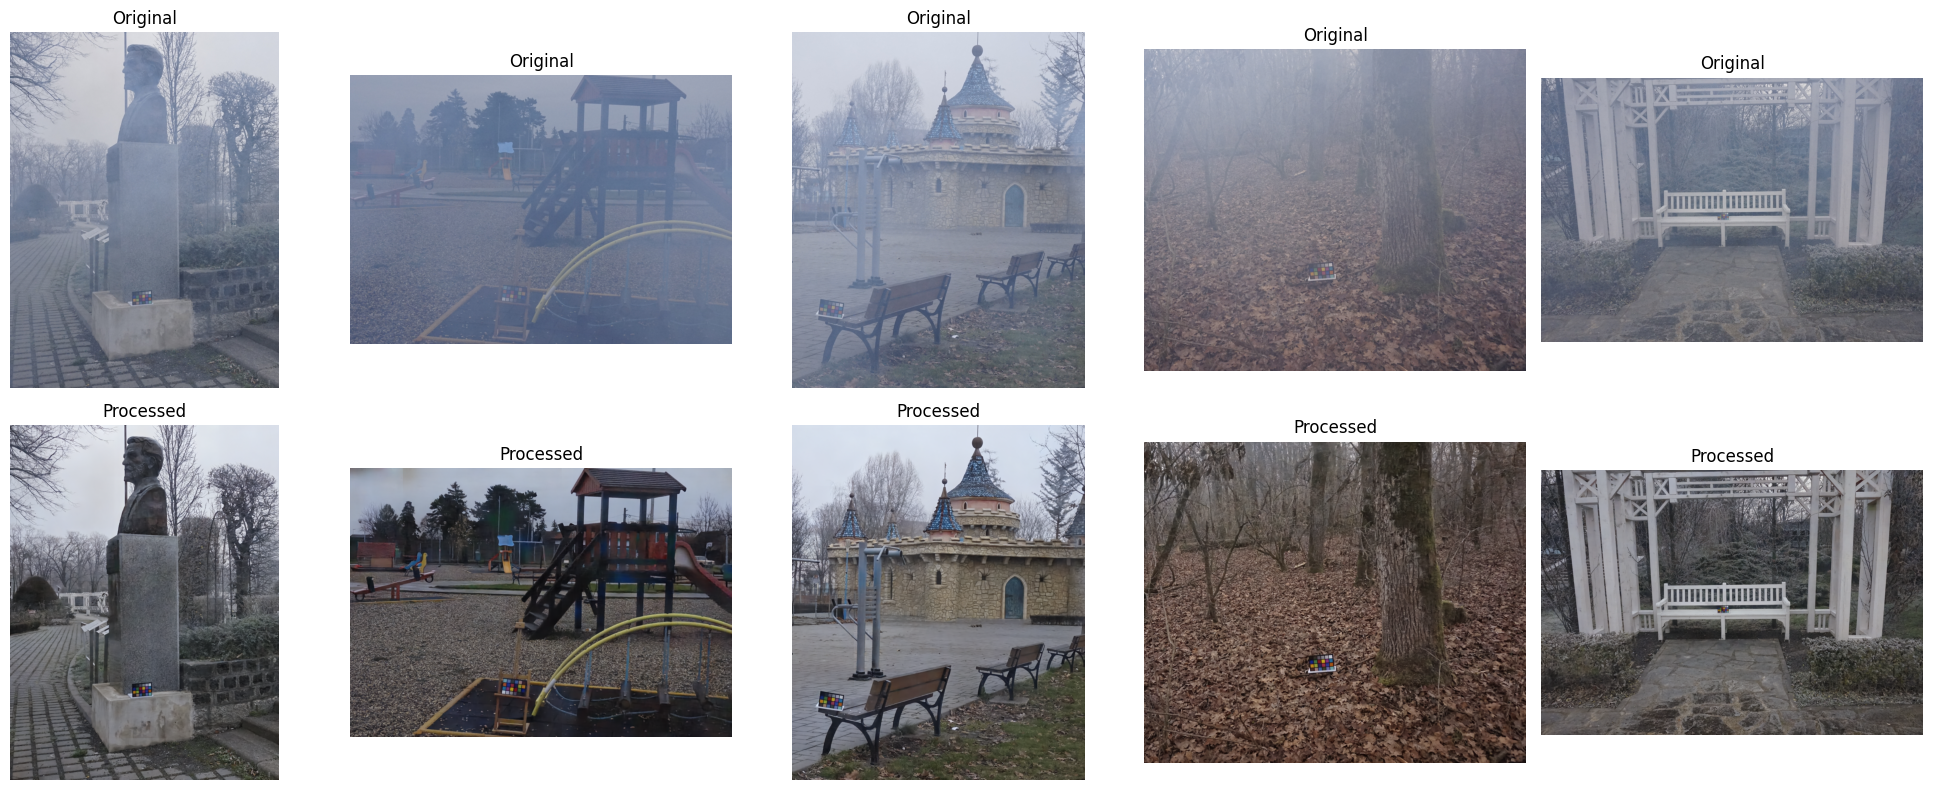

[O-Haze] L1: 0.043131, PSNR: 25.113143, SSIM: 0.774225


In [2]:
# coding: utf-8
import os

import numpy as np
import torch
from torch import nn
from torchvision import transforms

from tools.config import TEST_SOTS_ROOT, OHAZE_ROOT
from tools.utils import AvgMeter, check_mkdir, sliding_forward
from model import DM2FNet, DM2FNet_woPhy
from datasets import SotsDataset, OHazeDataset
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import matplotlib.pyplot as plt

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

torch.manual_seed(2018)
# torch.cuda.set_device(0)

ckpt_path = './ckpt'
# exp_name = 'RESIDE_ITS'
exp_name = 'O-Haze'

args = {
    # 'snapshot': 'iter_40000_loss_0.01230_lr_0.000000',
    # 'snapshot': 'iter_19000_loss_0.04261_lr_0.000014',
    # 'snapshot': 'iter_40000_loss_0.01244_lr_0.000000',
    'snapshot': 'iter_20000_loss_0.05144_lr_0.000000',
}

to_test = {
    # 'SOTS': TEST_SOTS_ROOT,
    'O-Haze': OHAZE_ROOT,
}

to_pil = transforms.ToPILImage()



def main():
    with torch.no_grad():
        criterion = nn.L1Loss().cuda()

        for name, root in to_test.items():
            if 'SOTS' in name:
                net = DM2FNet().cuda()
                dataset = SotsDataset(root)
            elif 'O-Haze' in name:
                net = DM2FNet_woPhy().cuda()
                dataset = OHazeDataset(root, 'test')
            else:
                raise NotImplementedError

            # net = nn.DataParallel(net)

            if len(args['snapshot']) > 0:
                print('load snapshot \'%s\' for testing' % args['snapshot'])
                net.load_state_dict(torch.load(os.path.join(ckpt_path, exp_name, args['snapshot'] + '.pth')))

            net.eval()
            dataloader = DataLoader(dataset, batch_size=1)

            psnrs, ssims = [], []
            loss_record = AvgMeter()

            plt.figure(figsize=(20, 8))
            for idx, data in enumerate(dataloader):
                # haze_image, _, _, _, fs = data
                haze, gts, fs = data
                # print(haze.shape, gts.shape)

                check_mkdir(os.path.join(ckpt_path, exp_name,
                                         '(%s) %s_%s' % (exp_name, name, args['snapshot'])))

                haze = haze.cuda()

                if 'O-Haze' in name:
                    res = sliding_forward(net, haze).detach()
                else:
                    res = net(haze).detach()

                loss = criterion(res, gts.cuda())
                loss_record.update(loss.item(), haze.size(0))

                for i in range(len(fs)):
                    r = res[i].cpu().numpy().transpose([1, 2, 0])
                    gt = gts[i].cpu().numpy().transpose([1, 2, 0])
                    psnr = peak_signal_noise_ratio(gt, r)
                    psnrs.append(psnr)
                    ssim = structural_similarity(gt, r, data_range=1, multichannel=True, channel_axis = 2,
                                                 gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
                    ssims.append(ssim)
                    print('predicting for {} ({}/{}) [{}]: PSNR {:.4f}, SSIM {:.4f}'
                          .format(name, idx + 1, len(dataloader), fs[i], psnr, ssim))
                    #show
                    if idx >= 5:
                        break
                    original_img = haze[i].cpu().numpy().transpose([1, 2, 0])
                    processed_img = r
                    plt.subplot(2, 5, idx + i + 1)
                    plt.imshow(original_img)
                    plt.title('Original')
                    plt.axis('off')
                    plt.subplot(2, 5, idx + 5 + i + 1)
                    plt.imshow(processed_img)
                    plt.title('Processed')
                    plt.axis('off')
                    # plt.subplot(2, 5, i + 1)
                    # plt.imshow(original_img)
                    # plt.title('Original')
                    # plt.axis('off')
                    # plt.subplot(2, 5, 5 + i + 1)
                    # plt.imshow(processed_img)
                    # plt.title('Processed')
                    # plt.axis('off')

                
                    
                for r, f in zip(res.cpu(), fs):
                    to_pil(r).save(
                        os.path.join(ckpt_path, exp_name,
                                     '(%s) %s_%s' % (exp_name, name, args['snapshot']), '%s.png' % f))
            plt.tight_layout()
            plt.show()
            print(f"[{name}] L1: {loss_record.avg:.6f}, PSNR: {np.mean(psnrs):.6f}, SSIM: {np.mean(ssims):.6f}")


if __name__ == '__main__':
    main()
